<center> <font size="7"> Documentation : qtm_single_marker_tracker </font> </center>
    
___
    Pierre BAGNARA
    pierre.bagnara@ecole-air.fr
    31 Mai 2022
___
    
<center> Ce Notebook est associé au projet Python "qtm_single_marker_tracker", développé avec le logiciel PyCharm. <br> 
    Il contient des cellules de code Python 3 directement exécutables (par le raccourci-clavier shift+Entrée une fois la cellule sélectionnée). </center> 

In [1]:
# --- Réinitialise les fonctions, variables et classes Python internes au document --- #
%reset -f

# ---- Import des librairies Python utiles pour ce Notebook ---- #
from IPython.display import Image

___

# Pré-requis
___

## Généralités

Avant toute utilisation du programme, plusieurs conditions et remarques sont à prendre en compte.
- Le projet a été développé en Python 3.6.9 à l'aide du logiciel PyCharm Community Edition sous Ubuntu 18.04 Bionic LTS. Les versions plus récentes de Python et d'Ubuntu devraient normalement prendre en charge le projet, mais il est conseillé d'utiliser la même configuration que celle citée précédemment.
- Un répertoire en ligne a été créé sur GitHub pour garder une trace de l'évolution du projet et pour pouvoir l'installer sur n'importe quel PC équipé d'une connexion à Internet. Il est conseillé de mettre à jour régulièrement ce répertoire (ou une copie) pour sauvegarder les modifications apportées aux programmes.
- Après avoir installé le projet sur un PC à partir de GitHub, il est nécessaire de sélectionner l'interpréteur du projet pour pouvoir exécuter les programmes.
- Les librairies Python citées dans le fichier requirements.txt doivent être installées, si possible dans leurs versions les plus récentes. __Note : Lors de l'ouverture du fichier requirements.txt et si le PC est connecté à Internet, PyCharm affiche une pop-up et propose d'installer un module qui interprète directement le fichier et installe automatiquement les librairies et leurs dépendences.__

## Règles de sécurité
___

### De manière générale
La mise en oeuvre d'un ou plusieurs drones comporte des risques, et je conseille vivement à quiconque serait à proximité des drone de respecter les règles de sécurité basiques proposées ci-dessous pour minimiser son exposition au danger :
- Veiller à ce qu'aucun drone ne soit sous tension en dehors de son volume de vol prévu (exception faite lors de la connexion au drone par un cable USB);
- Veiller à ce qu'aucune personne ne soit dans l'arène de vol lorsque la LED avant-gauche du drone est allumée (cela signifie que le drone est connecté par radio, et qu'il peut donc décoller à tout moment).

### Batteries
Les batteries Lithium Polymère utilisées sur les drones sont le principal facteur de risque, notamment en raison de leur tendance à s'enflammer spontanément lorsqu'elles ne sont pas utilisées correctement. Ces batteries sont en effet sensibles à la perforation, au courant de charge et de décharge, à la température et à la tension de la cellule. <br> 
Pour limiter les prises de risque, les règles suivantes sont à respecter :
- Veiller à ce que la conservation longue durée des batteries se fasse dans de bonnes conditions (sacs imifugés, à l'abri des sources de chaleur et de la lumière du soleil, niveau de charge des batteries entre 23 et 30%.
- Veiller au bon état des batteries utilisées sur les drones, ne pas utiliser de batterie gonflée ni endommagée (la perforation de l'enveloppe provoque un incendie violent).
- Veiller à ne pas vider complètement une batterie pendant un vol (l'idéal est de ne jamais descendre en dessous de 20% de charge, soit une tension de 3.7V au repos). __Attention : une batterie déchargée à moins de 3.0V est définitivement hors d'usage, ne surtout pas essayer de la recharger !__
- Toujours utiliser un chargeur spécifique aux batteries LiPo pour les recharger, et ne pas charger les batteries sans surveillance (risque d'incendie si la tension dépasse 4.2V).

## Système de Motion Capture

Le système de Motion Capture (MoCap) utilisé lors du développement du projet est composé de 8 caméras Qualisys Miqus reliées à un PC dédié uniquement au traitement des données des caméras avec le logiciel Qualisys Track Manager 2020.2. Ce système couvre un volume de vol d'environ 4m x 4m x 1.50m. <br>
Sur le logiciel QTM il est conseillé de créer un projet dédié à ce programme pour garder en mémoire les réglages requis. Ces réglages sont expliqués par la suite :
- Dans la fenêtre ```Tools > Project Options``` :
    * Dans l'onglet ```Input devices > Camera System```, la fréquence de capture des marqueurs est fixée à 100Hz, mais pour des raisons de vitesse de calcul, les données sont envoyées en temps réel à une fréquence réduite à 50Hz. __Note : l'exécution du programme est rythmée par la cadence de réception des données provenant de QTM. Un moyen efficace d'alléger la charge de calcul du PC qui gère le vol des drones est donc de réduire la fréquence d'émission des données par QTM. En revanche, il est déconseillé de la régler sur une valeur inférieure à 20Hz.__
    * Dans l'onglet ```Input devices > Camera System > Cameras``` : Les caméras sont toutes réglées avec le même temps d'exposition et de flash en mode marker : $ 400 \mu s$, et avec le même seuil de détection des marqueurs : 30%. En revanche, dans ```Exposure delay```, l'option "advanced" est sélectionnée, ce qui permet de régler un délai avant le flash de chacune des caméras. Afin qu'elles flashent l'une après l'autre pour ne pas se perturber entre elles, chacune des 8 caméras a son propre délai parmi la liste suivante : $ [0 \mu s, 1000 \mu s, 2000 \mu s, 3000 \mu s, 4000 \mu s, 5000 \mu s, 6000 \mu s, 7000 \mu s]$.
    * Dans l'onglet ```Input devices > Calibration``` : Le repère est défini tel que l'axe pointant vers le heut est l'axe Z positif, et l'axe suivant le bras le plus long de l'équerre est l'axe X positif.
    * Dans l'onglet ```Processing``` : Dans la partie 'Real time actions', seules les cases ```Process every frame``` et ```Track each frame in 3D``` sont cochées. __Attention à ne pas cocher la case ```Calculate 6DOF``` !__
    * Dans l'onglet ```Processing > Euler Angles``` : La définition des angles d'Euler est fixée sur "Custon", de type "Local", selon les paramètres du tableau suivant. 
    | Numéro de rotation | Axe de rotation | Sens positif | Nom | Intervalle |
    | --- | --- | --- | --- | --- |
    | 1 | Z | Clockwise (CW) | Yaw | [-180° ; 180°] |
    | 2 | Y | Counterclockwise (CCW) | Pitch | [-90° ; 90°] |
    | 3 | X | Clockwise (CW) | Roll | [-180° ; 180°] |
- La calibration doit être particulièrement soignée : les drones sont de petite taille et n'ont qu'un seul marqueur pour être repérés, le tracking doit donc être précis et fiable sur l'entièreté du volume de vol. A titre d'indication, lors du développement de ce projet, la durée de calibration a été réglée sur 20min et les résultats obtenus sont affichés ci-dessous.

In [8]:
Image(filename='Images/Calibration_results.jpg')

FileNotFoundError: [Errno 2] No such file or directory: 'Images/Calibration_results.jpg'

## Drones Crazyflie
___

Une application open-source développée en Python par Bitcraze, le constructeur des drones Crazyflie, permet de configurer les drones et de les tester individuellement avant de les faire voler en essaim de manière automatique. Cette application a pour nom ```cfclient``` et peut être installée depuis le site officiel de Bitcraze. <br>
__Note : le cfclient propose un onglet "Qualisys" avec des fonctions directement intégrées pour faire voler un Crazyflie asservi en position grâce à QTM. Cependant, cet onglet est souvent défectueux dans les versions les plus récentes du cfclient. Je conseille donc de ne pas passer trop de temps à essayer d'utiliser cette fonctionnalité__ _(Avant de développer ce projet, j'ai déjà essayé de modifier le code source du cfclient pour rendre cet onglet opérationnel, cela a fonctionné pendant quelques semaines, puis la mise à jour vers une nouvelle version de l'application a rendu l'onglet défectueux à nouveau)._

### Description du drone
___

Quelques caractéristiques importantes sont à noter sur le drone Crazyflie

#### Avant / Arrière et sens de rotation des hélices



#### LED

- La LED avant gauche donne une indication sur la qualité du signal radio. Lorsque le drone n'est pas connecté, la LED est éteinte, elle s'allume en vert lorsque la qualité du signal est bonne, et devient progressivement orange lorsque la qualité du signal se dégrade.
- La LED avant droit (de couleur rouge) du Crazyflie permet d'obtenir des informations sur son état : le drone est dans son état nominal lorsque cette LED clignote rapidement (~ 2 fois par seconde). Si cette LED clignote lentement (~ 1 fois toutes les 2 secondes), l'estimation d'attitude n'est pas correctement calibrée et il est nécessaire de poser le drone sur une surface plane avant toute tentative de décollage. Si la LED reste allumée, le drone n'a pas suffisamment d'énergie pour commencer un vol, et il est nécessaire de changer sa batterie.
- Les deux LED arrières (de couleur bleue) sont allumées dès lors que le drone est sous tension, le firmware du drone ne permet pas d'en modifier facilement le comportement.

### Première connexion

A partir du cfclient, la toute première connexion à un drone Crazyflie s'effectue par usb en branchant le Crazyflie au PC utilisé. Ensuite, le bouton "scan" permet d'identifier le drone et de déverouiller le bouton Connect pour l'interface "usb://0". Il est dès lors possible de se connecter au Crazyflie. <br>
Une fois la connexion établie, on observe un retour d'informations concernant le drone en temps réel, comme par exemple son attitude dans l'onglet ```Flight Control```. <br>
Dans la fenêtre ```Connect > Configure 2.X```, plusieurs paramètres doivent être renseignés pour pouvoir se connecter au drone par radio. Il est préférable d'attributer un numéro de "radio channel" unique pour chaque drone, de régler la "Radio bandwidth" sur la plus grande valeur proposée, et d'attribuer une adresse unique pour chaque drone en suivant le format standard suivant : "0xE7E7E7E7XX" (en remplaçant XX par le numéro du drone en question). <br>
__Note : il est vivement conseillé de noter ce numéro sur une étiquette et de la coller sur le drone correspondant pour l'identifier visuellement.__

### Connection par radio et check-list pré-vol

Avant chaque vol, je conseille vivement d'appliquer la procédure détaillée par la suite, qui permet de vérifier le bon état du drone tout au long des étapes de préparation du vol. <br>
- La première étape est un contrôle visuel du drone. On vérifie : 
    * l'état de surface des hélices (pas de dégâts sur les bords d'attaque ni de fissure).
    * le bon positionnement des hélices (certaines tournent dans le sens horaire, d'autres tournent dans le sens anti-horaire), et leur bon maintien sur l'axe moteur.
    * les axes des moteurs (pas tordus, propres : attention aux cheveux et fibres textiles qui peuvent s'enrouler autour des axes et s'accumuler à leur base)
    * le bon maintien des moteurs dans leurs emplacements.
    * le bon maintien des supports de moteur (pas de jeu, pas de dégâts au niveau des pattes).
    * le bon état de la batterie (pas gonflée, pas de choc apparent) et son bon maintien dans son emplacement.
    * le bon état des cosses permettant de brancher la batterie (pas pincées, isolation des fils électriques en bon état) <br><br>
    
- Le vol manuel permis par le cfclient utilise une manette de xbox 360 pour contrôler le drone. On vérifie donc le bon fonctionnement de la manette et la bonne lecture des entrées par le cfclient avant de se connecter au drone. __Note : le branchement d'une manette n'est pas forcément détecté par le cfclient lorsqu'il est déjà ouvert, il peut être nécessaire de redémarrer le cfclient.__ Dans l'onglet ```Flight control```, la partie "Gamepad input" montre en temps réel les commandes lues par le cfclient.

- Le drone peut ensuite être déposé dans son volume de vol et mis sous tension. Il est alors possible de s'y connecter par radio depuis le cfclient en sélectionant son adresse, puis en appuyant sur le bouton Scan (plusieurs appuis peuvent être nécessaires, en particulier si le drone a été mis sous tension récemment). Une fois le drone détecté avec l'interface "radio://0/XX/YY/E7E7E7E7ZZ" (XX = Radio channel, YY = Radio bandwidth, ZZ = Numéro du drone), le bouton Connect est déverouillé et la connexion au drone par radio peut s'établir. __Note : dès lors que le drone est connecté, il est contrôlé par la manette --> attention aux faux mouvements !__

- Quelques contrôles supplémentaires de l'état du drone sont désormais disponibles :
    * Le niveau de batterie.
    * La qualité de la liaison par radio.
    * L'équilibrage des rotors : dans l'onglet ```Console``` (qui peut être affiché depuis ```View > Tabs```), un bouton "Propeller test" est disponible. Ce test permet de faire tourner chaque hélice l'une après l'autre, et de récupérer l'écart type des signaux des accéléromètres. On obtient alors une représentation de l'intensité des vibrations causées par la rotation de chaque hélice. Des vibrations trop importantes peuvent altérer le maintien en position des hélices, ce qui entraîne un risque de décrochement et de projection de ces dernières pendant le vol. Il est donc conseillé de surveiller régulièrement ces résultats, notamment après un crash. <br> Les valeurs limites d'écart type tolérées par le cfclient sont de 2.50, en pratique il est conseillé d'éviter de faire voler un drone si l'un des écarts type dépasse 1.30. <br> Pour atténuer les vibrations causées par les hélices, une méthode simple consiste à les faire tourner par rapport à leurs axes moteurs respectifs, et de trouver itérativement l'écart type minimum qui correspond à la situation où les balourds des moteurs sont compensés au mieux par les balourds des hélices.

### Essai en vol

Une fois la check-list pré-vol terminée et le drone connecté par radio, un vol d'essai permet d'assurer la validation de la dynamique du vol du drone. Le drone est par défaut paramétré en mode attitude, il n'est donc pas asservi en position ni en vitesse. Les commandes sont difficiles à maîtriser sans expérience, c'est pourquoi j'invite le télépilote à rester très humble sur ses objectifs de vol. <br>
Ici, le but n'est pas de trouver les limites du drone mais de s'assurer que son comportement est sain avant d'implémenter les asservissements.

### Check-list post-vol

Après avoir posé et déconnecté le drone, deux contrôles principaux permettent d'identifier d'éventuels problèmes sur le drone immédiatement après le vol : le contrôle de la température des moteurs, et le contrôle de la température de la batterie. <br>
__Attention : Ne surtout pas mettre en charge une batterie qui vient d'être utilisée sans lui laisser le temps de refroidir.__

# Objectifs
___


Le but de ce projet est d'utiliser les fonctions proposées par les bibliothèqes Python ```cflib``` et ```qtm``` pour automatiser la gestion de vol des drones Crazyflie. <br>
Plusieurs fonctions de gestion d'essaim sont implémentées, comme par exemple un mode de consensus en hauteur, ou alors des manoeuvres anti-abordage et anti-collision automatisées. <br>
Ce Notebook permet de présenter le fonctionnement du programme en dressant dans un premier temps son architecture globale, puis en détaillant les étapes de calcul dans l'ordre chronologique d'exécution des commandes.

# Architecture du projet
___

Ce projet est composé de 6 scripts Python interconnectés. <br> 
Le programme principal est contenu dans le script ```main.py```, et chaque autre script peut être vu comme un module en charge d'une tâche ou d'une séquence de tâches spécifique, sur lequel le programme principal s'appuie pour fonctionner correctement.

Le schéma présenté dans la cellule suivante permet d'illustrer les liens entre les différents scripts, et les classes échangées via ces liens.

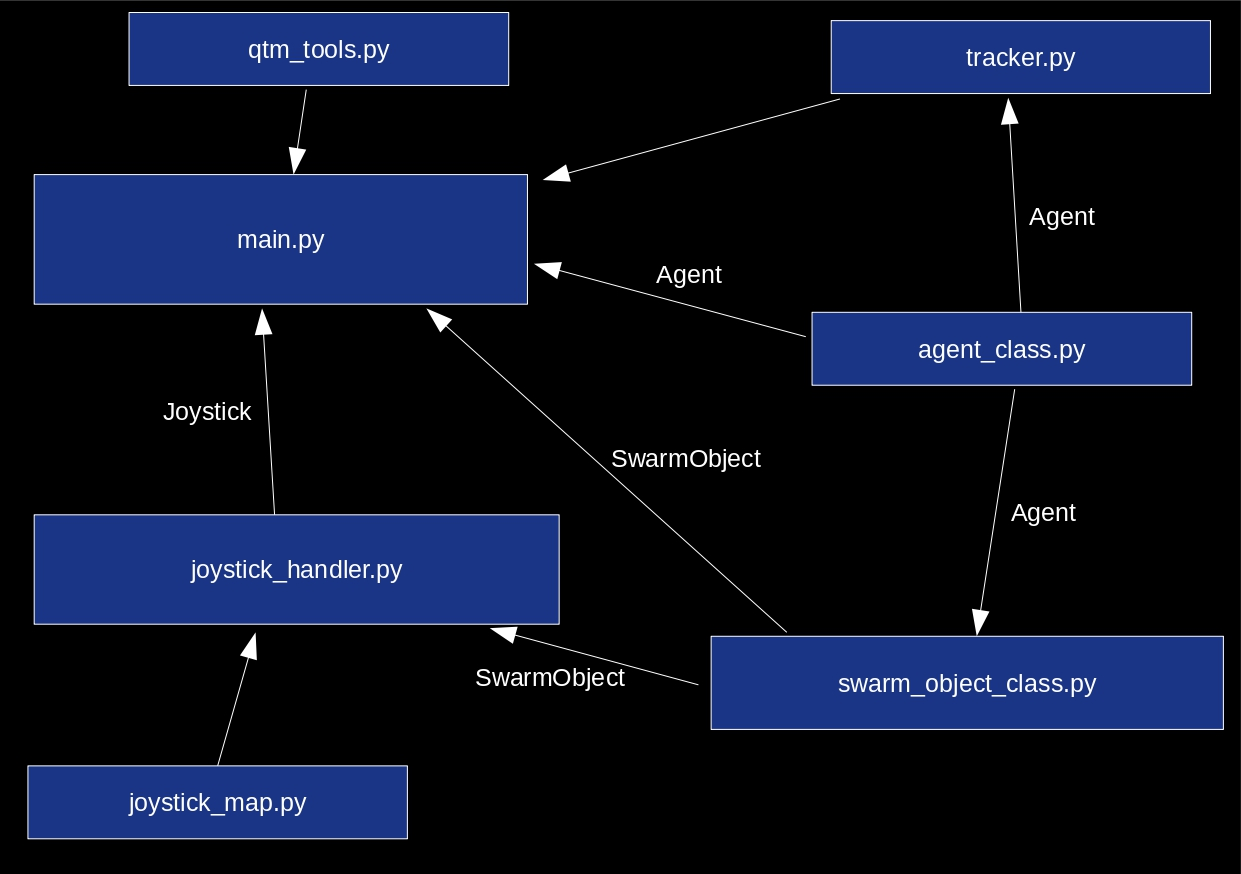

In [11]:
Image(filename='Images/Program_architecture.jpg')

## agent_class.py : élément de base

Le script agent_class.py contient uniquement la définition d'un classe nommée ```Agent```. Une instance de cette classe est attribuée à chaque drone, et permet de regrouper toutes les informations et les fonctions qui concernent directement le drone associé, comme par exemple les éléments de la liste non-exhaustive qui suit.
- Les éléments de la librairie ```cflib``` qui permettent de communiquer au drone par radio sont accessibles depuis l'attribut ```Agent.cf```
- La procédure de connexion et de paramétrage du drone au démarrage est codée à partir de la fonction ```Agent.connect_cf()```.
- Les paramètres de limite de volume de vol sont réglables avec les attributs ```Agent.x_boundaries```, ```Agent.y_boundaries``` et ```Agent.z_boundaries```.
- La position du drone est stockée à l'aide de l'attribut ```Agent.extpos```, qui regroupe les coordonnées en x, y et z, et qui peut être mis à jour avec la fonction ```Agent.update_extpos(marker, timestamp)```.
- Le mode de vol du drone est indiqué dans l'attribut ```Agent.state```. Cet attribut est une chaîne de caractères qui décrit le comportement du drone associé (valuers possibles : "Not flying", "Standby", "Takeoff", "Land", etc...)

## tracker.py : fonctions utiles à la localisation

# Ordre chronologique d'exécution des commandes
___

Dans cette partie, les parties du programme sont expliquées dans leur ordre chronologique d'exécution

## Paramètres de vol

Le début du programme est situé dans le script ```main.py```, à la ligne 
```python
if __name__ == '__main__':
```
A partir de cette ligne, on définit les différents paramètres nécessaires à l'exécution du programme. <br>
On commence par entrer l'adresse IP du serveur QTM : ```qtm_ip_address```, sous forme de chaîne de caractères, puis on crée une liste d'agents ```all_agents```, qui représente chaque drone disponible sous la forme d'une instance de la classe ```swarm_object_class.Agent```. La création d'un Agent nécessite deux arguments : son nom sous la forme d'une chaîne de caractères (arbitraire mais en évitant les doublons), et son URI sous la forme 'radio://R/CC/BB/E7E7E7E7XX' (avec R : numéro du dongle radio, CC Radio Channel, BB : Radio bandwidth, XX : Numéro du drone). <br>
Ensuite, on règle les paramètres de vol de chaque drone individuellement. Parmi ces paramètres, on trouve :
- La position initiale avant décollage (coordonnées [x, y, z] en m). __Attention : cette position sert à associer chaque drone à un marqueur dans l'arène, il est donc nécessaire d'assurer la cohérence entre la position initiale déclarée et la position initiale réelle du drone.__
- La hauteur ciblée lors du décollage (en m).
- La connectivité du drone pour le mode de consensus en hauteur (le nom des drones qui seront pris en compte par la loi de commande pour établir le consensus).
- La liste de noms des agents à éviter (ces agents seront pris en compte pour la gestion des manoeuvres anti-abordage).

Une fois que tous les agents sont déclarés et paramétrés, on crée une liste ```agents```, qui contient uniquement les agents qui seront utilisés sur le prochain vol. Cette liste reprend alors seulement les éléments qui nous intéressent dans la liste ```all_agents```.



## Connection à QTM et acquisition de la première frame

Pour se connecter à QTM, on fait appel à la fonction ```connect_to_qtm``` définie dans le script ```qtm_tools.py```.
Cette fonction est en réalité une fonction asychrone à exécuter dans une coroutine asyncio. Elle permet de fragmenter l'ordre d'exécution du code pour gérer la communication avec le serveur QTM en parallèle de la suite de l'exécution du programme.

Pour exécuter ce type de fonction, on affecte la coroutine qui lui est associée dans une boucle d'évènements.
Plusieurs cas de figure sont à recenser :
- Si la fonction est unique et ne doit être exécutée qu'une seule fois, on utilisera la commande suivante : 
```python
asyncio.get_event_loop().run_until_complete(fonction)
```
- Si une ou plusieurs fonctions asynchrones doivent être exécutées en parallèle de manière continue, on les intègre dans un premier temps dans une boucle d'évènements, puis on lance l'exécution de cette boucle :
```python
asyncio.ensure_future(fonction_1)
asyncio.ensure_future(fonction_2)
asyncio.get_event_loop().run_forever()
```

